In [1]:
import talib as ta
import joblib
import pandas as pd
import seaborn as sns
import datetime as datetime

In [2]:
pd.core.common.is_list_like = pd.api.types.is_list_like
pd.set_option('expand_frame_repr', False)  

In [3]:
start_time = datetime.datetime(1980, 1, 1)
end_time = datetime.datetime.now().date().isoformat() #today

In [4]:
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import time

#newest yahoo API 
import yfinance as yahoo_finance

In [5]:
def get_data(ticker):
    # daily historical data
    connected = False
    while not connected:
        try:
            df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   

    df = df.reset_index()
    return df

In [6]:
def compute_technical_indicators(df):
    
    #exponential moving average from talib
    df['EMA5'] = ta.EMA(df['Adj Close'].values, timeperiod=5)
    df['EMA10'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    df['EMA15'] = ta.EMA(df['Adj Close'].values, timeperiod=15)
    df['EMA20'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    df['EMA30'] = ta.EMA(df['Adj Close'].values, timeperiod=30)
    df['EMA40'] = ta.EMA(df['Adj Close'].values, timeperiod=40)
    df['EMA50'] = ta.EMA(df['Adj Close'].values, timeperiod=50)

    df['EMA60'] = ta.EMA(df['Adj Close'].values, timeperiod=60)
    df['EMA70'] = ta.EMA(df['Adj Close'].values, timeperiod=70)
    df['EMA80'] = ta.EMA(df['Adj Close'].values, timeperiod=80)
    df['EMA90'] = ta.EMA(df['Adj Close'].values, timeperiod=90)
    
    df['EMA100'] = ta.EMA(df['Adj Close'].values, timeperiod=100)
    df['EMA150'] = ta.EMA(df['Adj Close'].values, timeperiod=150)
    df['EMA200'] = ta.EMA(df['Adj Close'].values, timeperiod=200)

    #bbands from talib
    df['upperBB'], df['middleBB'], df['lowerBB'] = ta.BBANDS(df['Adj Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    #parabolic sar
    df['SAR'] = ta.SAR(df['High'].values, df['Low'].values, acceleration=0.02, maximum=0.2)

    # normalized relative strength indicator
    df['RSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14)
    df['normRSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14) / 100.0
    
    df.tail()
    return df

In [7]:
def compute_features(df):
    # computes features
    df['aboveEMA5'] = np.where(df['Adj Close'] > df['EMA5'], 1, 0)
    df['aboveEMA10'] = np.where(df['Adj Close'] > df['EMA10'], 1, 0)
    df['aboveEMA15'] = np.where(df['Adj Close'] > df['EMA15'], 1, 0)
    df['aboveEMA20'] = np.where(df['Adj Close'] > df['EMA20'], 1, 0)
    df['aboveEMA30'] = np.where(df['Adj Close'] > df['EMA30'], 1, 0)
    df['aboveEMA40'] = np.where(df['Adj Close'] > df['EMA40'], 1, 0)
    
    df['aboveEMA50'] = np.where(df['Adj Close'] > df['EMA50'], 1, 0)
    df['aboveEMA60'] = np.where(df['Adj Close'] > df['EMA60'], 1, 0)
    df['aboveEMA70'] = np.where(df['Adj Close'] > df['EMA70'], 1, 0)
    df['aboveEMA80'] = np.where(df['Adj Close'] > df['EMA80'], 1, 0)
    df['aboveEMA90'] = np.where(df['Adj Close'] > df['EMA90'], 1, 0)
    
    df['aboveEMA100'] = np.where(df['Adj Close'] > df['EMA100'], 1, 0)
    df['aboveEMA150'] = np.where(df['Adj Close'] > df['EMA150'], 1, 0)
    df['aboveEMA200'] = np.where(df['Adj Close'] > df['EMA200'], 1, 0)

    df['aboveUpperBB'] = np.where(df['Adj Close'] > df['upperBB'], 1, 0)
    df['belowLowerBB'] = np.where(df['Adj Close'] < df['lowerBB'], 1, 0)
    
    df['aboveSAR'] = np.where(df['Adj Close'] > df['SAR'], 1, 0)
   
    df['oversoldRSI'] = np.where(df['RSI'] < 30, 1, 0)
    df['overboughtRSI'] = np.where(df['RSI'] > 70, 1, 0)


    # cleanup NaN values
    df=df.fillna(0).copy()
    
    df.tail()

    return df

In [8]:
def plot_train_data(df):
    # plot price
    plt.figure(figsize=(15,2.5))
    plt.title('Stock data ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'])
    #plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()
    return None

In [43]:
def define_target_condition(df):
 
    # price higher later - bad predictive results
    #df['target_cls'] = np.where(df['Adj Close'].shift(-34) > df['Adj Close'], 1, 0)    
    
    # price above trend multiple days later
    df['target_cls'] = np.where(df['Adj Close'].shift(-34) > df['EMA150'].shift(-34), 1, 0)

    # important, remove NaN values
    df=df.fillna(0).copy()
    
    df.tail()
    
    return df

In [10]:
tickers = ['F', 'IBM', 'GE', 'AAPL', 'ADM',
           'XOM', 'GM','MMM','KO','PEP','SO','GS']           
#           'HAS','PEAK','HPE','HLT','HD','HON','HRL','HST','HPQ','HUM','ILMN', 
#           'INTC','ICE','INTU','ISRG','IVZ','IRM','JNJ','JPM','JNPR','K','KMB', 
#           'KIM', 'KMI','KSS','KHC', 'KR',  'LB', 'LEG', 'LIN', 'LMT','LOW',
#           'MAR', 'MA','MCD','MDT', 'MRK', 'MET', 'MGM', 'MU','MSFT', 'MAA', 
#           'MNST', 'MCO','MS', 'MSI',
#           'MMM', 'ABT','ACN','ATVI','ADBE','AMD','A','AKAM','ARE','GOOG','AMZN','AAL']

In [11]:
# parent dataframe to append to
ticker = 'SPY'
df = get_data(ticker)
df = compute_technical_indicators(df)
df = compute_features(df)
df = define_target_condition(df)

for ticker in tickers:
    t_df = get_data(ticker)
    t_df = compute_technical_indicators(t_df)
    t_df = compute_features(t_df)
    t_df = define_target_condition(t_df)
    
    df = df.append(t_df, ignore_index=True)

connected to yahoo
connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


connected to yahoo


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/1740819259.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(t_df, ignore_index=True)


In [12]:
predictors_list = ['aboveSAR','aboveUpperBB','belowLowerBB','normRSI','oversoldRSI','overboughtRSI',
                   'aboveEMA5','aboveEMA10','aboveEMA15','aboveEMA20','aboveEMA30','aboveEMA40',
                   'aboveEMA50','aboveEMA60','aboveEMA70','aboveEMA80','aboveEMA90','aboveEMA100']

In [45]:
def splitting_and_training(df, predictors_list, test_size=0.3):
    # __predictors__


    # __features__
    X = df[predictors_list].fillna(0).values
    #X.tail()

    # __targets__
    y_cls = df["target_cls"].fillna(0).values
    #y_cls.tail(10)

    # __train test split__
    from sklearn.model_selection import train_test_split
    y=y_cls
    X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    print (X_cls_train.shape, y_cls_train.shape)
    print (X_cls_test.shape, y_cls_test.shape)

    return X_cls_train, X_cls_test, y_cls_train, y_cls_test

In [14]:
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
import torch.nn.functional as F

In [15]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,100)
        self.layer2 = nn.Linear(100, 30)
        self.layer3 = nn.Linear(30, 2)
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.drop(x)
        x = F.relu(self.layer2(x))
        x = self.drop(x)
        x = F.softmax(self.layer3(x)) # To check with the loss function
        return x

In [16]:
features_train,features_test, labels_train, labels_test = splitting_and_training(df, predictors_list)

(86103, 18) (86103,)
(36902, 18) (36902,)


In [17]:
features_train[:3]

array([[0.        , 0.        , 0.        , 0.54741633, 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [0.        , 0.        , 0.        , 0.57093774, 0.        ,
        0.        , 0.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [0.        , 0.        , 0.        , 0.67301448, 0.        ,
        0.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ]])

In [18]:
labels_train[:3]

array([1, 0, 1])

In [19]:
# make data tensors
features_train = Variable(torch.Tensor(features_train).float())
features_test  = Variable(torch.Tensor(features_test).float())
labels_train   = Variable(torch.Tensor(labels_train).long())
labels_test    = Variable(torch.Tensor(labels_test).long())

x_train = features_train
y_train = labels_train

In [20]:
# Training
model = Model(features_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()
epochs = 150

def print_(loss):
    print ("The loss calculated: ", loss)

In [21]:
# Not using dataloader
#######x_train, y_train = Variable(torch.from_numpy(features_train)).float(), Variable(torch.from_numpy(labels_train)).long()
for epoch in range(1, epochs+1):
    print ("Epoch #",epoch)
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    print_(loss.item())
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward() # Gradients
    optimizer.step() # Update

Epoch # 1
The loss calculated:  0.6957269906997681
Epoch # 2
The loss calculated:  0.6654825806617737


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/4287727945.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.layer3(x)) # To check with the loss function


Epoch # 3
The loss calculated:  0.6406000256538391
Epoch # 4
The loss calculated:  0.6204590797424316
Epoch # 5
The loss calculated:  0.6047304272651672
Epoch # 6
The loss calculated:  0.5937396287918091
Epoch # 7
The loss calculated:  0.5878052711486816
Epoch # 8
The loss calculated:  0.58531653881073
Epoch # 9
The loss calculated:  0.5837362408638
Epoch # 10
The loss calculated:  0.5825903415679932
Epoch # 11
The loss calculated:  0.5805859565734863
Epoch # 12
The loss calculated:  0.5779961347579956
Epoch # 13
The loss calculated:  0.5747324228286743
Epoch # 14
The loss calculated:  0.5713788866996765
Epoch # 15
The loss calculated:  0.5683207511901855
Epoch # 16
The loss calculated:  0.5659242868423462
Epoch # 17
The loss calculated:  0.5647310018539429
Epoch # 18
The loss calculated:  0.5640944242477417
Epoch # 19
The loss calculated:  0.5637778639793396
Epoch # 20
The loss calculated:  0.5637022256851196
Epoch # 21
The loss calculated:  0.5635647177696228
Epoch # 22
The loss calc

In [22]:
x_test = features_test

pred = model(x_test)

/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/4287727945.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.layer3(x)) # To check with the loss function


In [23]:
pred = pred.detach().numpy()

In [24]:
pred

array([[6.6141176e-01, 3.3858824e-01],
       [7.0873684e-01, 2.9126313e-01],
       [1.0695129e-04, 9.9989307e-01],
       ...,
       [5.9606403e-01, 4.0393603e-01],
       [3.4843793e-05, 9.9996519e-01],
       [6.8511528e-01, 3.1488475e-01]], dtype=float32)

In [25]:
print("The accuracy is", accuracy_score(labels_test, np.argmax(pred, axis=1)))

The accuracy is 0.7348924177551353


In [26]:
# Checking for first value
np.argmax(model(x_test[0]).detach().numpy(), axis=0)

/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/4287727945.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.layer3(x)) # To check with the loss function


0

In [27]:
labels_test[0]

tensor(0)

In [28]:
torch.save(model, "iris-pytorch.pkl")

In [29]:
saved_model = torch.load("iris-pytorch.pkl")

In [30]:
np.argmax(saved_model(x_test[0]).detach().numpy(), axis=0)

/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/4287727945.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.layer3(x)) # To check with the loss function


0

In [31]:
x_test[0]

tensor([0.0000, 0.0000, 0.0000, 0.4664, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [32]:
for i in x_test[:3]:
    print(i)
    prediction = np.argmax(saved_model(i).detach().numpy(), axis=0)
    print('prediction', prediction)

tensor([0.0000, 0.0000, 0.0000, 0.4664, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
prediction 0
tensor([0.0000, 0.0000, 0.0000, 0.4721, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
prediction 0
tensor([0.0000, 0.0000, 0.0000, 0.5717, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
prediction 1


/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/4287727945.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.layer3(x)) # To check with the loss function


In [33]:
#====END OF TRAINING=======

In [34]:
#ticker='BP'
#ticker='ABBV'
#ticker='GILD'
#ticker='NGG'
#ticker='BPY'
ticker='MSFT'

In [35]:
def plot_stock_prediction(df, ticker):
    # plot  values and significant levels
    plt.figure(figsize=(30,7))
    plt.title('Predictive model ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close', alpha=0.2)

    plt.plot(df['Date'], df['EMA10'], label='EMA10', alpha=0.2)
    plt.plot(df['Date'], df['EMA20'], label='EMA20', alpha=0.2)
    plt.plot(df['Date'], df['EMA30'], label='EMA30', alpha=0.2)
    plt.plot(df['Date'], df['EMA40'], label='EMA40', alpha=0.2)
    plt.plot(df['Date'], df['EMA50'], label='EMA50', alpha=0.2)
    plt.plot(df['Date'], df['EMA100'], label='EMA100', alpha=0.2)
    plt.plot(df['Date'], df['EMA150'], label='EMA150', alpha=0.99)
    plt.plot(df['Date'], df['EMA200'], label='EMA200', alpha=0.2)


    plt.scatter(df['Date'], df['Buy']*df['Adj Close'], label='Buy', marker='^', color='magenta', alpha=0.15)
    #lt.scatter(df.index, df['sell_sig'], label='Sell', marker='v')

    plt.legend()

    plt.show()

    return None   

In [36]:
new_df = get_data(ticker)

connected to yahoo


In [37]:
new_df = compute_technical_indicators(new_df)
new_df = compute_features(new_df)
new_df=define_target_condition(new_df)
saved_model = torch.load("iris-pytorch.pkl")

In [38]:
def predict_timeseries(df):
    
    # making sure we have good dimensions
    # column will be rewritten later
    df['Buy'] = df['target_cls']
    
    for i in range(len(df)):
        X_cls_valid = [[df['aboveSAR'][i],df['aboveUpperBB'][i],df['belowLowerBB'][i],
                        df['normRSI'][i],df['oversoldRSI'][i],df['overboughtRSI'][i],
                        df['aboveEMA5'][i],df['aboveEMA10'][i],df['aboveEMA15'][i],df['aboveEMA20'][i],
                        df['aboveEMA30'][i],df['aboveEMA40'][i],df['aboveEMA50'][i],
                        df['aboveEMA60'][i],df['aboveEMA70'][i],df['aboveEMA80'][i],df['aboveEMA90'][i],
                        df['aboveEMA100'][i]]]    

        x_test = Variable(torch.Tensor(X_cls_valid).float())    
        
        #####print('x_test',x_test)
        

        #####print('i',i)
        prediction = np.argmax(saved_model(x_test[0]).detach().numpy(), axis=0)
        #####print('prediction', prediction)        
  
    
        df['Buy'][i] = prediction


    print(df.head())    
        
    return df

In [39]:
new_df = predict_timeseries(new_df)

/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/4287727945.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.layer3(x)) # To check with the loss function
/var/folders/4v/79hzqsnj155_2r8_zvw_2cn80000gn/T/ipykernel_23268/972954555.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Buy'][i] = prediction


        Date      High       Low      Open     Close        Volume  Adj Close      EMA5  EMA10  EMA15  ...  aboveEMA100  aboveEMA150  aboveEMA200  aboveUpperBB  belowLowerBB  aboveSAR  oversoldRSI  overboughtRSI  target_cls  Buy
0 1986-03-13  0.101563  0.088542  0.088542  0.097222  1.031789e+09   0.060980  0.000000    0.0    0.0  ...            0            0            0             0             0         0            0              0           1    0
1 1986-03-14  0.102431  0.097222  0.097222  0.100694  3.081600e+08   0.063158  0.000000    0.0    0.0  ...            0            0            0             0             0         0            0              0           1    0
2 1986-03-17  0.103299  0.100694  0.100694  0.102431  1.331712e+08   0.064247  0.000000    0.0    0.0  ...            0            0            0             0             0         0            0              0           1    0
3 1986-03-18  0.103299  0.098958  0.102431  0.099826  6.776640e+07   0.062613  0.000

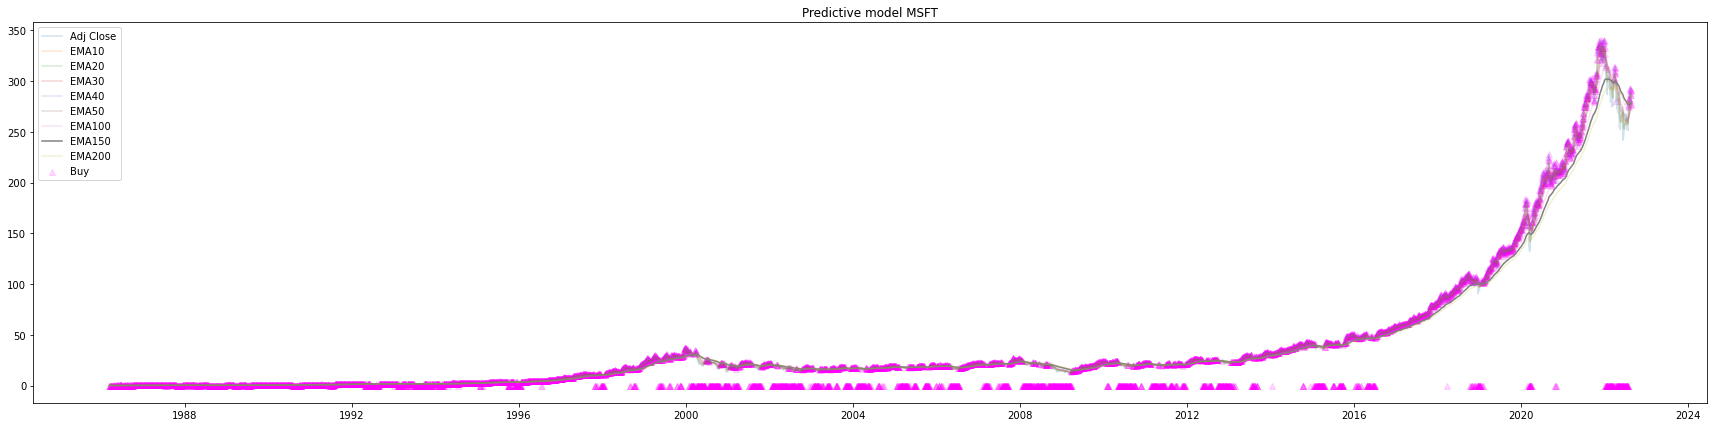

In [40]:
plot_stock_prediction(new_df, ticker)

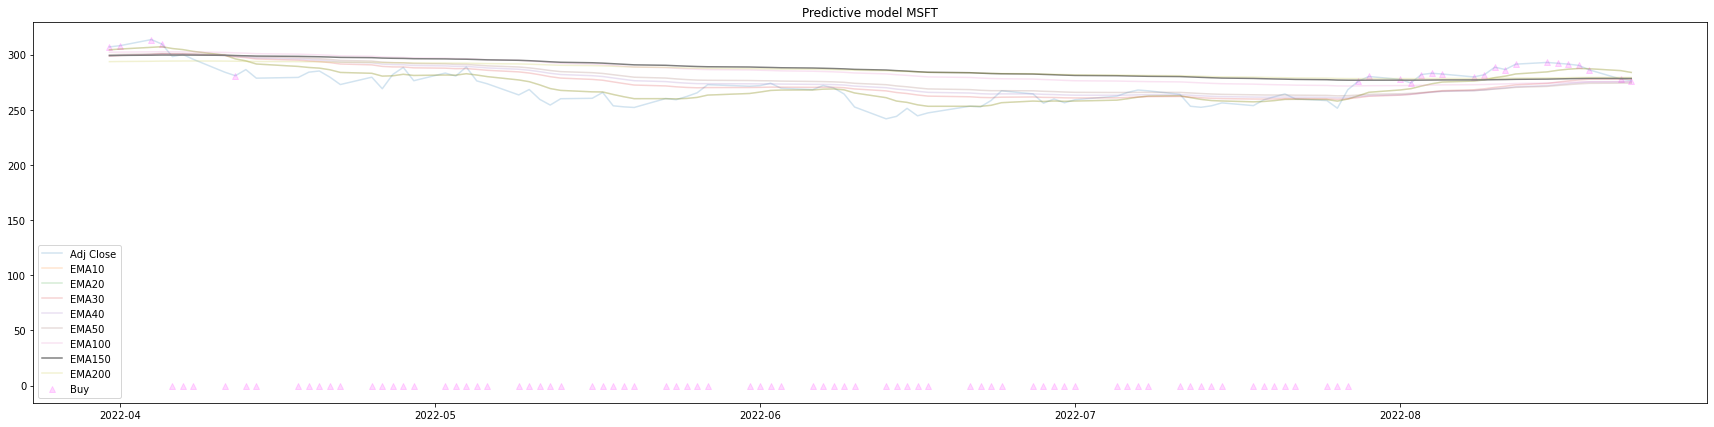

In [42]:
temp_df = new_df[-100:]
plot_stock_prediction(temp_df, ticker)